In [3]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
parser = argparse.ArgumentParser(description='heatmap creator')
parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

if bool(getattr(sys, 'ps1', sys.flags.interactive)):
    from tqdm import tqdm_notebook as tqdm
    print('interactive mode')
    parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
else:
    from tqdm import tqdm
    print('script mode')
    parsed = parser.parse_args(sys.argv[1:])
    display=print

print(parsed)

interactive mode
Namespace(alg='bn', data='alpha', output='-')


In [5]:
# alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# data_list = ['alpha', 'amazon', 'epinions', 'otc']
data_list = ['otc', 'alpha', 'epinions', 'amazon']
q_range = np.array([0.005, 0.01, 0.03, 0.05, 0.1])
met_list = ['f1', 'prec', 'recl']

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

../res/bn/eval-alpha.pkl


KeyError: 0.005

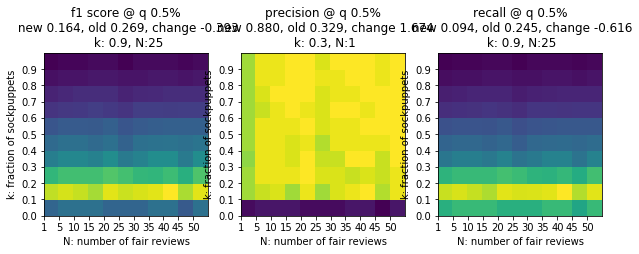

In [175]:
fig, ret, ret_sc = create_heatmaps(alg='bn', data='alpha')
display(pd.DataFrame(ret))
display(pd.DataFrame(ret_line))

#fig, ret = create_heatmaps(alg='feagle', data='amazon')
#display(pd.DataFrame(ret))
#fig, ret = create_heatmaps(alg='trust', data='otc')
#display(pd.DataFrame(ret))

In [6]:
from collections import defaultdict

data_list = ['otc','alpha','epinions','amazon']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
markers = ["o", "v", "8", "s", "P", "*", "+"]

def compute_uchange():     #fig, ax, plot_data, title=''
    
    u_change_dict = {}     #u_change_dict[alg_id][met][q] = average_uchange = sum of u_change / # of valid dataset
    
    for alg_id in range(len(alg_list)): 
        u_change_dict[alg_id] = {}     
        for met in met_list:
            u_change_dict[alg_id][met] = {}
            
        for data in data_list:         
            eval_path = '../res/%s/eval-%s.pkl' %(alg_list[alg_id], data)                            
            try:
                with open(eval_path, 'rb') as fp:
                    metrics_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
                continue
            
            print(alg_list[alg_id], data)
            
            eval_path = '../res/%s/res-%s.pkl' %(alg_list[alg_id], data)
            try:
                with open(eval_path, 'rb') as fp:
                    results_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
                continue    
            
            q_dict = {}
            for q in range(5):
                heat_dict = {'f1': np.empty([10, 11]), 'prec': np.empty([10, 11]), 'recl': np.empty([10, 11])}
                try:
                    for k, n in itertools.product(range(10), range(11)):
                        ytrue = np.mean([results_dict[(k, n_range[n], ind)]['ytrue'] for ind in range(50)]);
                        yscore = np.mean([results_dict[(k, n_range[n], ind)]['yscore'] for ind in range(50)]);
                        size = len(ytrue);
                        
                        cut = q_range(q) * size;
                        ypred = (np.arange(size) < cut) * 1
                        
                        total = 0
                        for id in range(size):
                            if ypred[id] == 1:
                                total += 1
                                if ytrue[id] == 1:
                                    truepos += 1
                        prec = truepos / total
                        heat_dict['prec'][k, n] = prec
             
                        heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
                       ## heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
                        heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
                    q_dict[q] = heat_dict   
                except TypeError:
#                    print("TypeError Here !")
                    continue
            
            for q in range(5):  
                for met in met_list:
                    try:
                        # div = 0
                        u_new = q_dict[q][met][1:, :].min()
                        u_old = q_dict[q][met][0, :].mean()

                        k_new, n_new = np.unravel_index(q_dict[q][met][1:, :].argmin(), q_dict[q][met][1:, :].shape)                
                        k_new += 1

                        u_change = (u_new - u_old) / u_old
                        u_change_dict[alg_id][met][q] = u_change_dict[alg_id][met].get(q, 0) + u_change
                        # div += 1
               
                    except KeyError:
                        # print("KeyError !!!!")
                        # div -= 1
                        continue
        
                    u_change_dict[alg_id][met][q] /= 5
                    
                     
    return u_change_dict
    
compute_uchange()


rev2 otc
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


{0: {'f1': {}, 'prec': {}, 'recl': {}},
 1: {'f1': {}, 'prec': {}, 'recl': {}},
 2: {'f1': {}, 'prec': {}, 'recl': {}},
 3: {'f1': {}, 'prec': {}, 'recl': {}},
 4: {'f1': {}, 'prec': {}, 'recl': {}},
 5: {'f1': {}, 'prec': {}, 'recl': {}},
 6: {'f1': {}, 'prec': {}, 'recl': {}}}

rev2 otc
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


ValueError: x and y must be the same size

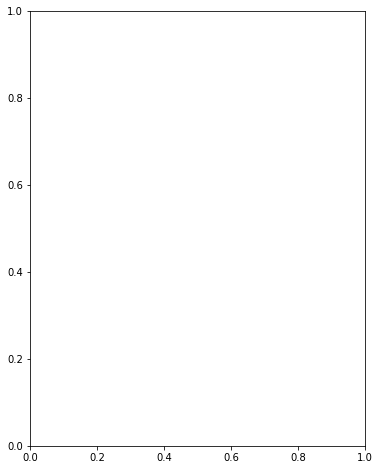

In [7]:
markers = ["o", "v", ">", "s", "P", "D", "x"]
def plot_scatters():
    
    u_change_dict = compute_uchange() 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)

        met = met_list[i]
        for alg_id in range(len(alg_list)):
        
            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), marker= markers[alg_id]) 

            ax.set_yticks([ -0.2, 0, 0.2, 0.4]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
            ax.set_yticklabels([ -0.2, 0, 0.2, 0.4]) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])

            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
            ax.legend(
                loc='lower left',
                ncol=3,
                fontsize=8)

plot_scatters()

#plot_scatterplots('bn', 'otc')
#plot_scatterplots('bn', 'amazon')
# plot_scatterplots('bn', 'epinions')
# plot_scatterplots('rsd', 'epinions')
#plot_scatterplots('fraudar', 'alpha')

In [47]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
    for data in data_list:
        print(alg, data)
        
        

rev2 otc
rev2 alpha
rev2 epinions
rev2 amazon
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


In [12]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
    for data in data_list:
        print(alg, data)
        figs, ret = create_heatmaps(alg, data)
        if figs != None:
            for i in range(len(figs)):
                fig = figs[i]
                fig.savefig('../res/heatmaps/%s-%s-%d.pdf' %(alg, data, i))
        plt.close('all')
        # pd.DataFrame(ret).to_csv('../res/heatmaps/%s-%s.csv' %(alg, data))
        for q in q_range:
            for met in met_list:
                if ret[q][met] != None:
                    reports[met][q][alg][data] = 'change=%.3f \n k=%.2f \n n=%d' %tuple(ret[q][met])
                else:
                    reports[met][q][alg][data] = ''

for met in met_list:
    for q in q_range:
        print(met, q)
        pd.DataFrame(reports[met][q]).to_csv('../res/heatmaps/%s-%.3f.csv' %(met, q))

rev2 otc
../res/rev2/eval-otc.pkl
rev2 otc not exists
rev2 alpha
../res/rev2/eval-alpha.pkl
rev2 epinions
../res/rev2/eval-epinions.pkl
rev2 epinions not exists
rev2 amazon
../res/rev2/eval-amazon.pkl
rev2 amazon not exists
bad otc
../res/bad/eval-otc.pkl
bad alpha
../res/bad/eval-alpha.pkl
bad epinions
../res/bad/eval-epinions.pkl
bad epinions not exists
bad amazon
../res/bad/eval-amazon.pkl
bn otc
../res/bn/eval-otc.pkl
bn alpha
../res/bn/eval-alpha.pkl
bn epinions
../res/bn/eval-epinions.pkl
bn epinions not exists
bn amazon
../res/bn/eval-amazon.pkl
trust otc
../res/trust/eval-otc.pkl
trust alpha
../res/trust/eval-alpha.pkl
trust epinions
../res/trust/eval-epinions.pkl
trust epinions not exists
trust amazon
../res/trust/eval-amazon.pkl
trust amazon not exists
feagle otc
../res/feagle/eval-otc.pkl
feagle alpha
../res/feagle/eval-alpha.pkl
feagle epinions
../res/feagle/eval-epinions.pkl
feagle epinions not exists
feagle amazon
../res/feagle/eval-amazon.pkl
fraudar otc
../res/fraudar/e